Este notebook incluye la solución propuesta para el Modulo 5. 

El NB consta de dos secciones:

       
 * Part 1: Enunciado del problema y código ya generado

 * Part 2: Solución propuesta

## ***Part 1: Module 5: Analyse, diagnose and improve a model​***

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [1]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [2]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text

In [3]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

### Cargar datos y preprocesamiento inicial

In [4]:
data_set = pd.read_feather("../../data/financials_against_return.feather")

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
data_set.head(5)

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,ChangeInInventories,CommonStockDividendsPaid,CommonStockNet,ComprehensiveIncome,CostOfGoodsSold,CurrentRatio,DaysSalesInReceivables,DebtIssuanceRetirementNet_minus_Total,DebtEquityRatio,EBIT,EBITMargin,EBITDA,EBITDAMargin,FinancialActivities_minus_Other,GoodwillAndIntangibleAssets,GrossMargin,GrossProfit,IncomeAfterTaxes,IncomeFromContinuousOperations,IncomeFromDiscontinuedOperations,IncomeTaxes,Inventory,InventoryTurnoverRatio,InvestingActivities_minus_Other,LongTermDebt,Long_minus_TermInvestments,Long_minus_termDebtCapital,NetAcquisitionsDivestitures,NetCashFlow,NetChangeInIntangibleAssets,NetChangeInInvestments_minus_Total,NetChangeInLong_minus_TermInvestments,NetChangeInPropertyPlantAndEquipment,NetChangeInShort_minus_termInvestments,NetCommonEquityIssuedRepurchased,NetCurrentDebt,NetIncome,NetIncomeLoss,NetLong_minus_TermDebt,NetProfitMargin,NetTotalEquityIssuedRepurchased,OperatingExpenses,OperatingIncome,OperatingMargin,OtherCurrentAssets,OtherIncome,OtherLong_minus_TermAssets,OtherNon_minus_CashItems,OtherNon_minus_CurrentLiabilities,OtherOperatingIncomeOrExpenses,OtherShareHoldersEquity,Pre_minus_PaidExpenses,Pre_minus_TaxIncome,Pre_minus_TaxProfitMargin,PropertyPlantAndEquipment,ROA_minus_ReturnOnAssets,ROE_minus_ReturnOnEquity,ROI_minus_ReturnOnInvestment,Receivables,ReceiveableTurnover,ResearchAndDevelopmentExpenses,RetainedEarningsAccumulatedDeficit,ReturnOnTangibleEquity,Revenue,SGAExpenses,ShareHolderEquity,Stock_minus_BasedCompensation,TotalAssets,TotalChangeInAssetsLiabilities,TotalCommonAndPreferredStockDividendsPaid,TotalCurrentAssets,TotalCurrentLiabilities,TotalDepreciationAndAmortization_minus_CashFlow,TotalLiabilities,TotalLiabilitiesAndShareHoldersEquity,TotalLongTermLiabilities,TotalLong_minus_TermAssets,TotalNon_minus_CashItems,TotalNon_minus_OperatingIncomeExpense,execution_date,close_0,close_sp500_0,stock_change_365,stock_change_div_365,sp500_change_365,stock_change_730,stock_change_div_730,sp500_change_730,stock_change__minus_120,stock_change_div__minus_120,sp500_change__minus_120,stock_change__minus_365,stock_change_div__minus_365,sp500_change__minus_365,stock_change__minus_730,stock_change_div__minus_730,sp500_change__minus_730,std_730,std__minus_120,std__minus_365,std__minus_730,Market_cap,n_finan_prev_year,Enterprisevalue,EBITDAEV,EBITEV,RevenueEV,CashOnHandEV,PFCF,PE,PB,RDEV,WorkingCapital,ROC,DividendYieldLastYear,EPS_minus_EarningsPerShare_change_1_years,EPS_minus_EarningsPerShare_change_2_years,FreeCashFlowPerShare_change_1_years,FreeCashFlowPerShare_change_2_years,OperatingCashFlowPerShare_change_1_years,OperatingCashFlowPerShare_change_2_years,EBITDA_change_1_years,EBITDA_change_2_years,EBIT_change_1_years,EBIT_change_2_years,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500
0,A,2005-01-31,0.1695,81.000,-57.000,137.000,2483.0000,5.000,44.000,-5.000,-13.000,NaN,5.000,215.000,621.000,2.6251,70.2475,23.000,0.3052,152.0000,3.1353,344.0000,NaN,NaN,459.000,48.7624,591.0000,43.0000,51.0000,52.0,15.000,1037.000,0.5988,-9.000,1150.000,NaN,0.2338,-10.000,672.000,NaN,-10.000,-10.000,-28.000,NaN,58.000,23.000,103.0000,103.000,NaN,8.4984,58.000,1174.000,38.0000,3.1353,183.000,NaN,807.000,33.000,461.000,NaN,NaN,NaN,58.0000,4.7855,1235.000,0.7133,1.3535,1.0370,946.000,1.2812,700.0,-1707.0000,1.5413,4848.0000,378.000,3768.0000,1.0,7150.0000,-47.000,NaN,4649.0000,1771.000,48.000,3382.000,7150.0000,1611.000,2501.000,81.000,20.0000,2005-06-30,15.5105,1191.32761,0.370982,0.370982,0.066209,0.772214,0.772214,0.26191,0.057341,0.057341,0.015743,0.271937,0.271937,-0.042383,-0.135100,-0.135100,-0.175443,0.017009,0.014371,0.020641,0.021253,7693.20

In [7]:
data_set.shape

(170483, 144)

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [8]:
df_quarte_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarte_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"] >= minimum_number_of_tickers]

In [9]:
data_set.shape

(170483, 145)

Create the target:

In [10]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]
data_set.loc[data_set["diff_ch_sp500"]>0, "target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0, "target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

### Funciones para entrenar y medir rendimiento del modelo

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [11]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

`get_weighted_performance_of_stocks`calcula el retorno promedio del portfolio

`get_top_ticker_per_prob` selecciona las `top_n` acciones con mayor probabilidad predicha

`top_wt_performance`evalua el retorno del portfolio basado en las predicciones (1º selecciona las top_n acciones usando `get_top_tickers_per_prob`, 2º calcula el retorno promedio de las acciones con `weighted_performance_of_stocks`)

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [12]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

`train_set`: Conjunto de entrenamiento con datos históricos (hasta 350 días antes de test_execution_date), sin valores nulos en diff_ch_sp500, y limitado a los últimos 36 (n_train_quarters) trimestres.

`test_set`: Datos de un único trimestre (execution_date especifico), sin valores nulos en diff_ch_sp500 y sin duplicados de Ticker.

Ensure that we don't include features which are irrelevant or related to the target:

Añadir stock_change_div_730

In [13]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "stock_change_div_730",
                         "sp500_change_365",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [14]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set):

    global params 
    global model

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [15]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test




Obtiene todas las fechas del dataset 

In [16]:
execution_dates = np.sort( data_set['execution_date'].unique() )
execution_dates

array(['2005-06-30T00:00:00.000000000', '2005-09-30T00:00:00.000000000',
       '2005-12-30T00:00:00.000000000', '2006-03-31T00:00:00.000000000',
       '2006-06-30T00:00:00.000000000', '2006-09-30T00:00:00.000000000',
       '2006-12-30T00:00:00.000000000', '2007-03-31T00:00:00.000000000',
       '2007-06-30T00:00:00.000000000', '2007-09-30T00:00:00.000000000',
       '2007-12-30T00:00:00.000000000', '2008-03-31T00:00:00.000000000',
       '2008-06-30T00:00:00.000000000', '2008-09-30T00:00:00.000000000',
       '2008-12-30T00:00:00.000000000', '2009-03-31T00:00:00.000000000',
       '2009-06-30T00:00:00.000000000', '2009-09-30T00:00:00.000000000',
       '2009-12-30T00:00:00.000000000', '2010-03-31T00:00:00.000000000',
       '2010-06-30T00:00:00.000000000', '2010-09-30T00:00:00.000000000',
       '2010-12-30T00:00:00.000000000', '2011-03-31T00:00:00.000000000',
       '2011-06-30T00:00:00.000000000', '2011-09-30T00:00:00.000000000',
       '2011-12-30T00:00:00.000000000', '2012-03-31

This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [17]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":40,
             "objective": "binary",
             "metric": "binary_logloss"}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [18]:
all_predicted_tickers.head(5)

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,ChangeInInventories,CommonStockDividendsPaid,CommonStockNet,ComprehensiveIncome,CostOfGoodsSold,CurrentRatio,DaysSalesInReceivables,DebtIssuanceRetirementNet_minus_Total,DebtEquityRatio,EBIT,EBITMargin,EBITDA,EBITDAMargin,FinancialActivities_minus_Other,GoodwillAndIntangibleAssets,GrossMargin,GrossProfit,IncomeAfterTaxes,IncomeFromContinuousOperations,IncomeFromDiscontinuedOperations,IncomeTaxes,Inventory,InventoryTurnoverRatio,InvestingActivities_minus_Other,LongTermDebt,Long_minus_TermInvestments,Long_minus_termDebtCapital,NetAcquisitionsDivestitures,NetCashFlow,NetChangeInIntangibleAssets,NetChangeInInvestments_minus_Total,NetChangeInLong_minus_TermInvestments,NetChangeInPropertyPlantAndEquipment,NetChangeInShort_minus_termInvestments,NetCommonEquityIssuedRepurchased,NetCurrentDebt,NetIncome,NetIncomeLoss,NetLong_minus_TermDebt,NetProfitMargin,NetTotalEquityIssuedRepurchased,OperatingExpenses,OperatingIncome,OperatingMargin,OtherCurrentAssets,OtherIncome,OtherLong_minus_TermAssets,OtherNon_minus_CashItems,OtherNon_minus_CurrentLiabilities,OtherOperatingIncomeOrExpenses,OtherShareHoldersEquity,Pre_minus_PaidExpenses,Pre_minus_TaxIncome,Pre_minus_TaxProfitMargin,PropertyPlantAndEquipment,ROA_minus_ReturnOnAssets,ROE_minus_ReturnOnEquity,ROI_minus_ReturnOnInvestment,Receivables,ReceiveableTurnover,ResearchAndDevelopmentExpenses,RetainedEarningsAccumulatedDeficit,ReturnOnTangibleEquity,Revenue,SGAExpenses,ShareHolderEquity,Stock_minus_BasedCompensation,TotalAssets,TotalChangeInAssetsLiabilities,TotalCommonAndPreferredStockDividendsPaid,TotalCurrentAssets,TotalCurrentLiabilities,TotalDepreciationAndAmortization_minus_CashFlow,TotalLiabilities,TotalLiabilitiesAndShareHoldersEquity,TotalLongTermLiabilities,TotalLong_minus_TermAssets,TotalNon_minus_CashItems,TotalNon_minus_OperatingIncomeExpense,execution_date,close_0,close_sp500_0,stock_change_365,stock_change_div_365,sp500_change_365,stock_change_730,stock_change_div_730,sp500_change_730,stock_change__minus_120,stock_change_div__minus_120,sp500_change__minus_120,stock_change__minus_365,stock_change_div__minus_365,sp500_change__minus_365,stock_change__minus_730,stock_change_div__minus_730,sp500_change__minus_730,std_730,std__minus_120,std__minus_365,std__minus_730,Market_cap,n_finan_prev_year,Enterprisevalue,EBITDAEV,EBITEV,RevenueEV,CashOnHandEV,PFCF,PE,PB,RDEV,WorkingCapital,ROC,DividendYieldLastYear,EPS_minus_EarningsPerShare_change_1_years,EPS_minus_EarningsPerShare_change_2_years,FreeCashFlowPerShare_change_1_years,FreeCashFlowPerShare_change_2_years,OperatingCashFlowPerShare_change_1_years,OperatingCashFlowPerShare_change_2_years,EBITDA_change_1_years,EBITDA_change_2_years,EBIT_change_1_years,EBIT_change_2_years,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count,target,prob
8051,TD,2006-01-31,0.0105,8049.80,-952.120,-6645.170,97038.950,NaN,NaN,NaN,NaN,NaN,5154.850,NaN,1871.680,NaN,NaN,0.000,2.4956,NaN,NaN,NaN,NaN,4285.000,8270.90,NaN,4231.866,2008.800,1977.099,0.0,188.540,NaN,NaN,730.160,6191.820,42595.47,0.2812,-701.880,385.200,NaN,-916.13,NaN,-64.270,NaN,NaN,3541.120,1977.099,1977.090,NaN,56.9069,485.060,3931.900,2171.646,NaN,NaN,NaN,47248.120,NaN,16314.7,NaN,-570.76,NaN,2197.340,63.2461,NaN,0.6002,12.7826,8.9774,NaN,NaN,NaN,10842.760,26.1504,18000.780,1682.290,15831.36,NaN,329411.100,-7594.730,-261.38,229838.800,288633.300,182.540,313579.700,329411.100,24946.390,98114.480,182.540,NaN,2006-06-30,25.483320,1270.20438,0.343890,0.373124,0.183549,0.242549,0.316127,0.007713,0.132029,0.114763,0.014908,-0.124695,-0.158442,-0.062098,-0.372490,-0.436061,-0.101849,0.013489,0.011074,0.009943,0.009740,36619.5306

In [19]:
all_predicted_tickers.shape

(148083, 147)

In [20]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [21]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [22]:
test_results.head()

,binary_logloss,weighted-return,n_trees,execution_date
0,0.718962,0.193742,0,2006-06-30
1,0.716195,0.246123,1,2006-06-30
2,0.715489,0.267459,2,2006-06-30
3,0.714979,0.218345,3,2006-06-30
4,0.712628,0.015834,4,2006-06-30


In [23]:
train_results

,binary_logloss,weighted-return,n_trees,execution_date
0,0.657505,0.267845,0,2006-06-30
1,0.639193,0.483940,1,2006-06-30
2,0.619754,0.218716,2,2006-06-30
3,0.601840,0.247316,3,2006-06-30
4,0.585715,0.250948,4,2006-06-30
...,...,...,...,...
35,0.621253,0.431394,35,2020-03-31
36,0.620597,0.487939,36,2020-03-31
37,0.619887,0.487939,37,2020-03-31
38,0.619180,0.487939,38,2020-03-31


In [24]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


In [25]:
test_results_final_tree.head(10)

,binary_logloss,weighted-return,n_trees,execution_date
39,0.759610,0.099404,39,2006-06-30
39,0.730303,0.035528,39,2006-09-30
39,0.715078,-0.052195,39,2006-12-30
39,0.710833,-0.067471,39,2007-03-31
39,0.711701,-0.045395,39,2007-06-30
39,0.813939,0.124543,39,2007-09-30
39,0.841405,0.176348,39,2007-12-30
39,0.773925,0.088931,39,2008-03-31
39,0.768846,-0.076386,39,2008-06-30
39,0.685414,0.105201,39,2008-09-30


In [26]:
train_results_final_tree.head()

,binary_logloss,weighted-return,n_trees,execution_date
39,0.276797,0.277172,39,2006-06-30
39,0.393084,0.236828,39,2006-09-30
39,0.446241,0.288516,39,2006-12-30
39,0.479211,0.209679,39,2007-03-31
39,0.496369,0.222281,39,2007-06-30


In [27]:
train_results_final_tree.tail()

,binary_logloss,weighted-return,n_trees,execution_date
39,0.624280,0.472214,39,2019-03-31
39,0.623344,0.404293,39,2019-06-30
39,0.622242,0.484938,39,2019-09-30
39,0.623151,0.428794,39,2019-12-30
39,0.618439,0.487939,39,2020-03-31


### Visualización de resultados

And this are the results:

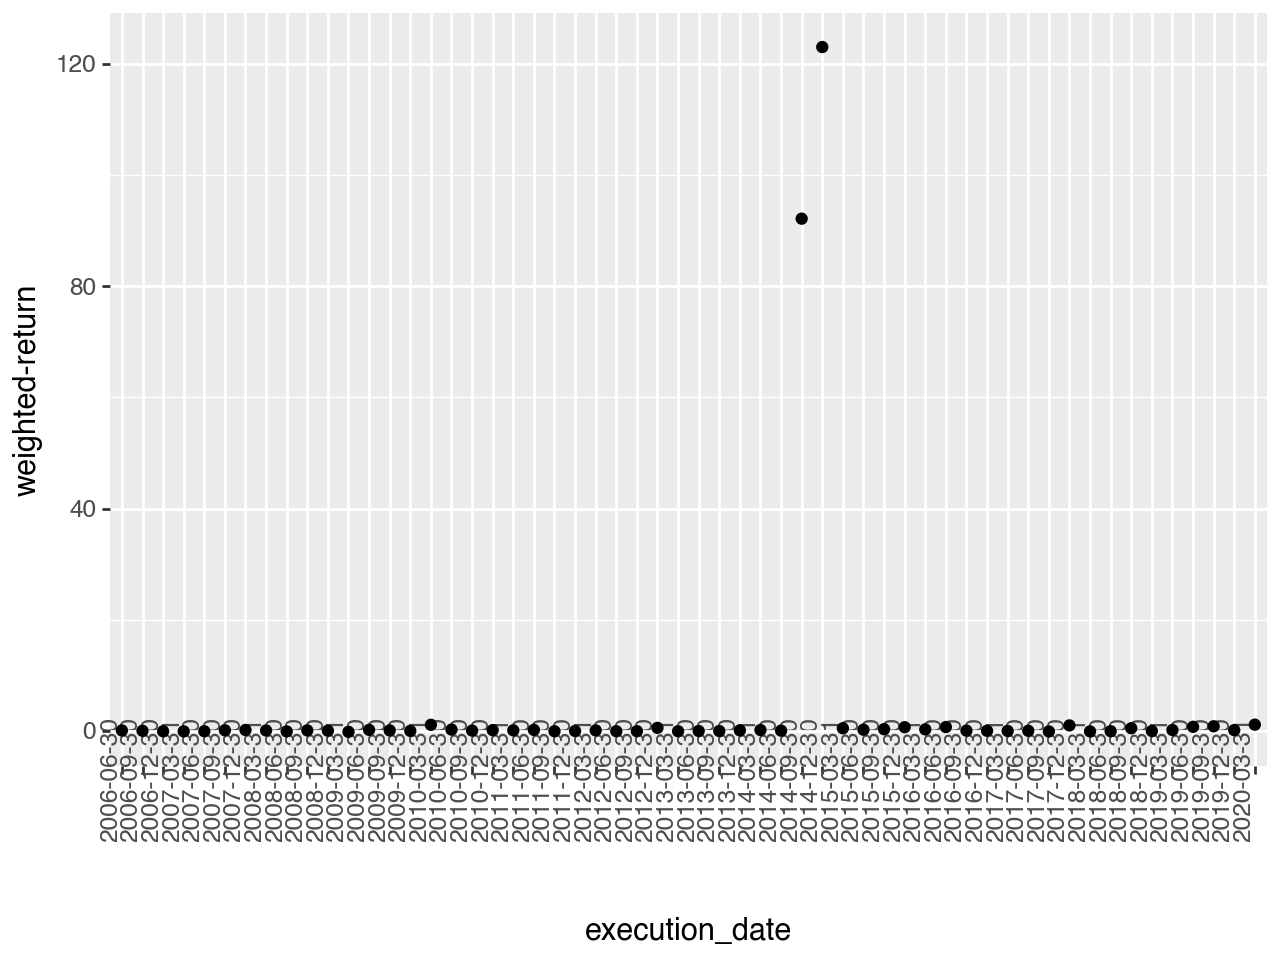

In [28]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



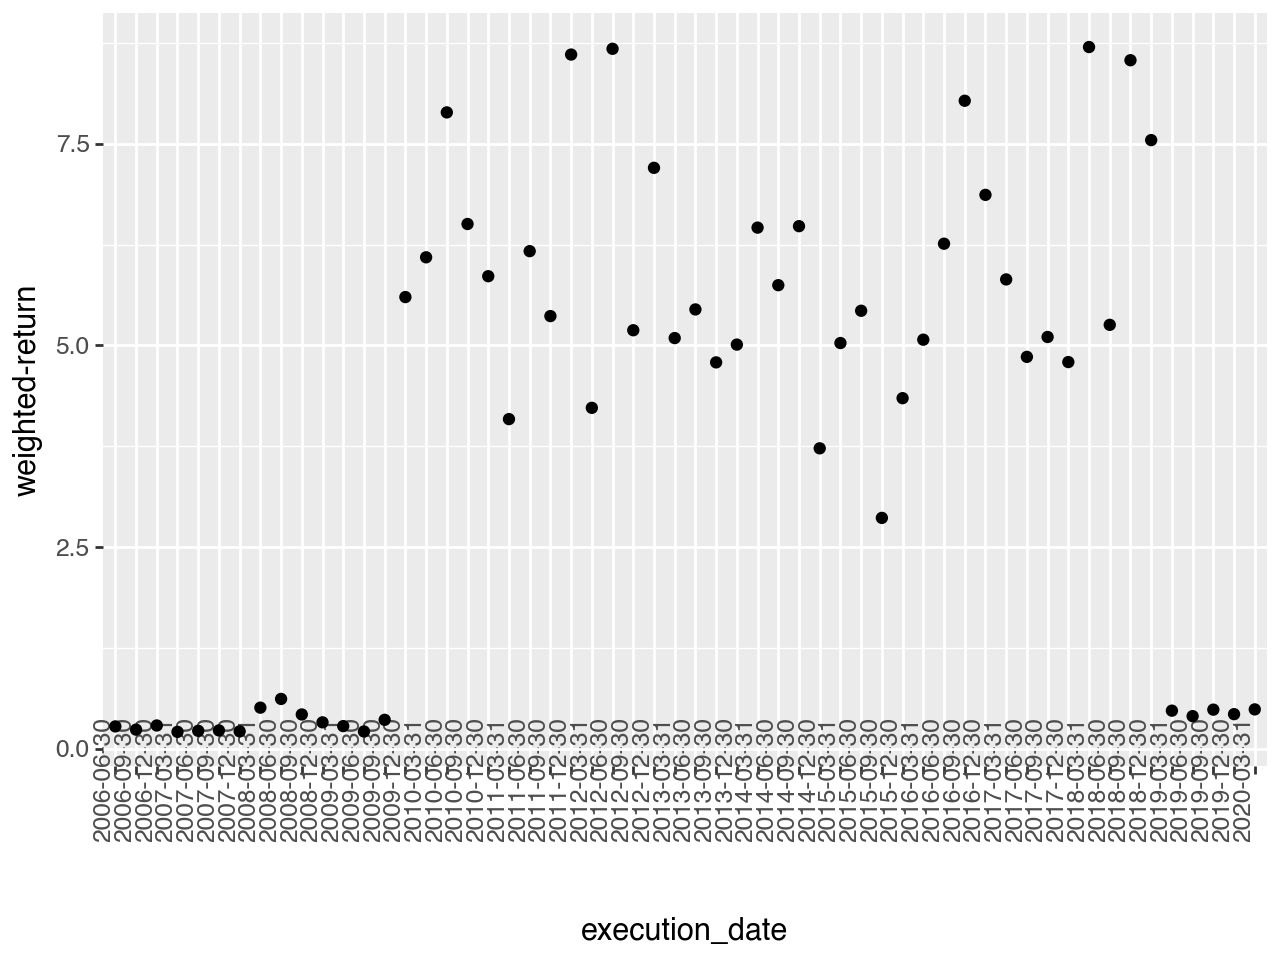

In [29]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [30]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


In [31]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# ***Part 2: Solution***

Una vez vista el código propuesto, el objetivo es encontrar donde esta fallando el modelo. Un weighted-return de 0,3, significa que nuestro portfolio mejora un 30% al SP500 en el proximo año, lo cual es ya un buen resultado, el problema es que nuestro modelo en train tiene muchos weighted-return muy altos, e.g. valores de 5 significarian mejorar un 500% lo cual hace sospechar que el modelo no es correcto

In [32]:
#for execution_date in np.sort(execution_dates):
#    if execution_date in all_models:
#        model = all_models[execution_date]
#        draw_feature_importance(model, execution_date)

Voy a calcular la media de Feature importance de todos los modelos entrenados 

In [33]:
def draw_feature_importance(model, execution_date, top=15):

    fi = model.feature_importance(importance_type="gain") 
    fn = [str(f) for f in model.feature_name()] 

    df = pd.DataFrame({"feature": fn, "imp": fi})
    df = df.sort_values("imp", ascending=False).head(top)

    plt.figure(figsize=(10, 6))
    plt.barh(df["feature"], df["imp"], color="lightblue")
    plt.gca().invert_yaxis()
    plt.title(f"Feature Importance - {pd.to_datetime(execution_date).strftime('%Y-%m-%d')}")
    plt.xlabel("Importance (Gain)")

In [34]:
def plot_average_feature_importance(all_models, top=15):
    all_dfs = []
    
    for execution_date in all_models:
        model = all_models[execution_date]
        fi = model.feature_importance(importance_type="gain")
        fn = [str(f) for f in model.feature_name()]
        df = pd.DataFrame({"feature": fn, "imp": fi})
        all_dfs.append(df)
    

    combined = pd.concat(all_dfs)
    avg_imp = combined.groupby("feature")["imp"].mean().reset_index()
    avg_imp["imp_pct"] = (avg_imp["imp"] / avg_imp["imp"].sum()) * 100  # Porcentaje
    

    avg_imp = avg_imp.sort_values("imp_pct", ascending=False).head(top)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    bars = ax.barh(avg_imp["feature"], avg_imp["imp_pct"], color="skyblue")
    ax.invert_yaxis()
    ax.set_title("Average Feature Importance (All Dates)")
    ax.set_xlabel("Average Importance (%)")
    plt.show()

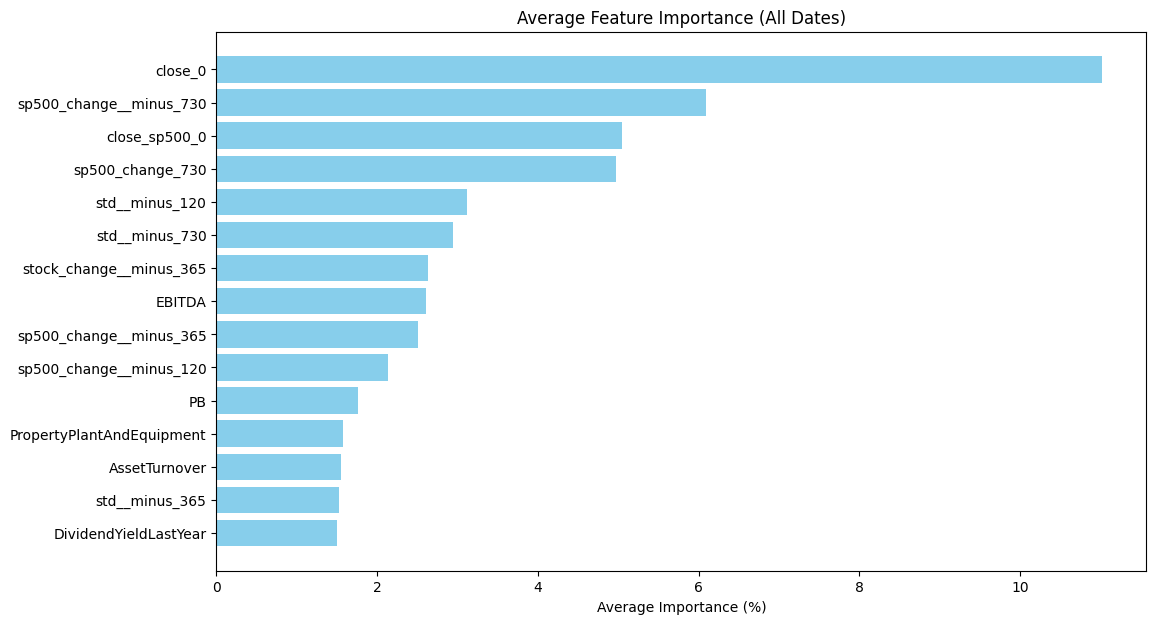

In [35]:
plot_average_feature_importance(all_models, top=15)

El metodo que utiliza LightGBm para calcular feature importance es ver cuanta information gain he ganado al dividir con esa feature concreta. Este tipo de feature importance tiene un sesgo a variables que tienen cardinalidad alta. Variables que aunque no sean muy importantes, voy a tener más probabilidad de escogerla para hacer un split

Las features más importantes son: 

* close_0 : precio de la acción en la execution_date

* sp500_change_minus_730 : % change of the SP500 in the last 2 years

* close_sp500_o : precio de SP500 en execution_date

No obstante, no tiene sentido hacer feature importance de un modelo que ya sabemos que es malo. La tarea es analizar el proceso del modelo para encontrar donde lo esta haciendo mal, y ya después podemos analizar esos resultados.

El primer paso en modelos de ML es definir un baseline sin ML que sirva de referencia, si no mejoramos ese baseline, no esta justificado el uso de ML.

### ***Baseline***

In [36]:
test_results_final_tree.head()

,binary_logloss,weighted-return,n_trees,execution_date
39,0.759610,0.099404,39,2006-06-30
39,0.730303,0.035528,39,2006-09-30
39,0.715078,-0.052195,39,2006-12-30
39,0.710833,-0.067471,39,2007-03-31
39,0.711701,-0.045395,39,2007-06-30


In [37]:
def merge_against_benchmark(metrics_df, all_predicted_tickers, top_n_market_cap= 500):
    all_predicted_tickers = all_predicted_tickers.sort_values(["execution_date", "Market_cap"], ascending = False)
    all_predicted_tickers["rank"] = all_predicted_tickers.groupby(["execution_date"]).cumcount()
    all_predicted_tickers_top_mc = all_predicted_tickers[all_predicted_tickers["rank"] <= 500]
    baseline = all_predicted_tickers_top_mc.groupby("execution_date")["diff_ch_sp500"].mean().reset_index()
    baseline = baseline.rename(columns ={"diff_ch_sp500":"diff_ch_sp500_baseline"})
    baseline["execution_date"] = baseline["execution_date"].astype(str)
    metrics_df =pd.merge(metrics_df, baseline, on="execution_date")
    return metrics_df

In [38]:
test_results_final_tree = merge_against_benchmark(test_results_final_tree, all_predicted_tickers)

In [39]:
test_results_final_tree.head()

,binary_logloss,weighted-return,n_trees,execution_date,diff_ch_sp500_baseline
0,0.759610,0.099404,39,2006-06-30,0.049213
1,0.730303,0.035528,39,2006-09-30,0.067796
2,0.715078,-0.052195,39,2006-12-30,0.068473
3,0.710833,-0.067471,39,2007-03-31,0.048029
4,0.711701,-0.045395,39,2007-06-30,0.077166


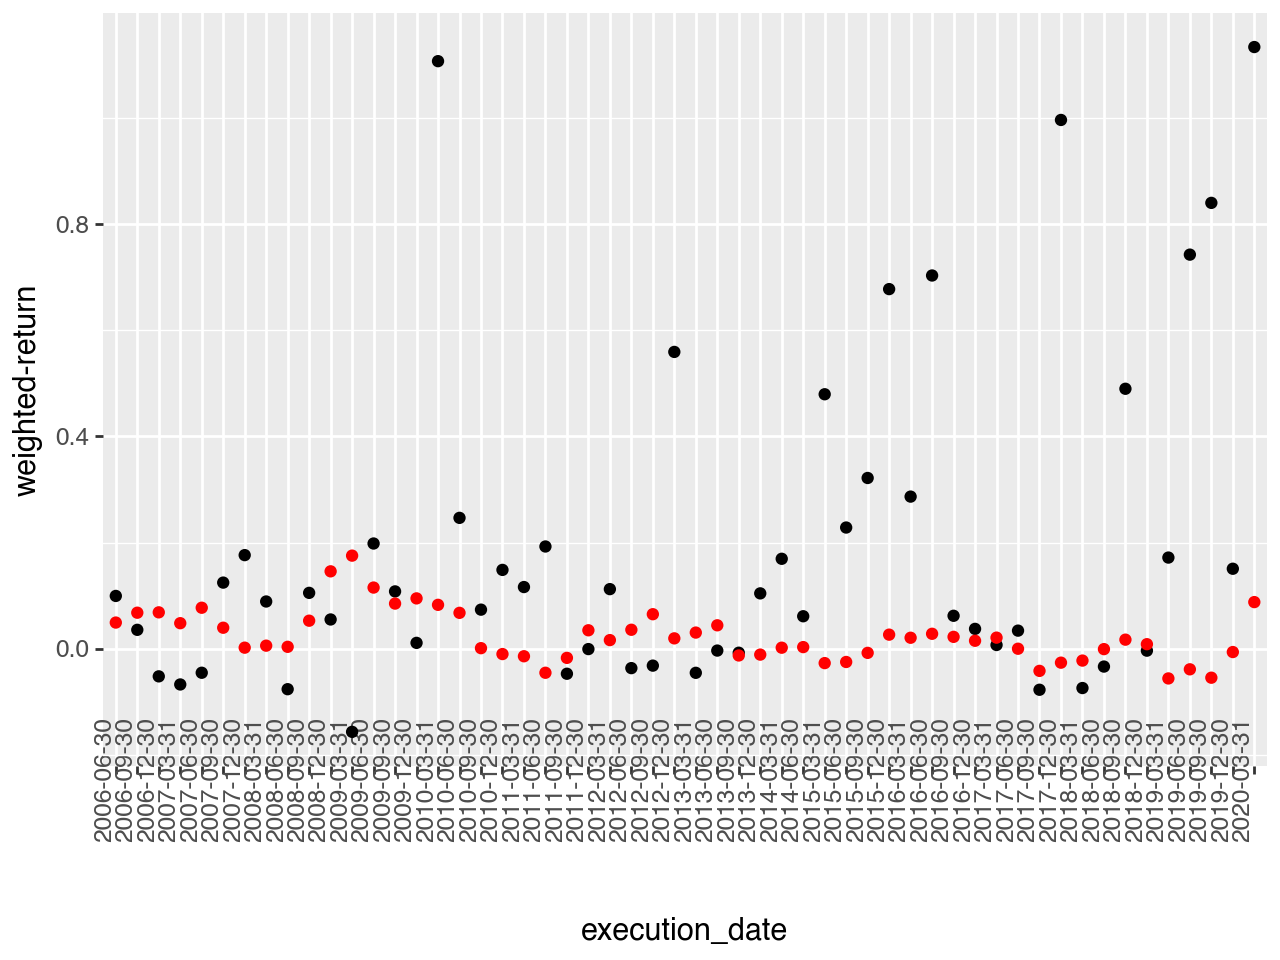

In [40]:
(ggplot(test_results_final_tree[test_results_final_tree["weighted-return"]<2])
+ geom_point(aes(x = "execution_date", y = "weighted-return"), color='black')
+ geom_point(aes(x= "execution_date", y ="diff_ch_sp500_baseline"), color="red")
+ theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))
)

La función `merge_against_benchmark` crea el baseline seleccionando para cada `execution_date`las 500 acciones con mayor capitalización de mercado (Market_cap)  y calculando el rendimiento promedio (`diff_ch_sp500` --> en 1 año) de las acciones seleccionadas vs S&P500

% de periodos en los que modelo es mejor que baseline:

In [41]:
periods_better_than_baseline = len(test_results_final_tree[test_results_final_tree['weighted-return']>test_results_final_tree["diff_ch_sp500_baseline"]])/len(test_results_final_tree)
print(f"{periods_better_than_baseline *100:.2f}")

66.07


Rendimiento de baseline vs modelo

In [42]:
test_results_final_tree["weighted-return"].median()

0.10471844503860958

In [43]:
test_results_final_tree["diff_ch_sp500_baseline"].median()

0.015525563344158869

In [44]:
test_results_final_tree["weighted-return"].mean()

4.029023035251342

In [45]:
test_results_final_tree["diff_ch_sp500_baseline"].mean()

0.022159133577893696

Comparando con el baseline, el rendimiento del modelo tiene una mediana x10, lo cual es una mejora brutal y nos tiene que hacer sospechar. Tenemos que averiguar si el modelo esta realmente **aprendiendo y generalizando** o esta haciendo overfitting. Una herramienta muy útil son las curvas de aprendizaje en train y test y ver como evoluciona la metrica que definamos con el aumento de arboles. En este caso, la metrica que nos interesa minimizar es binary_logloss.

In [46]:
all_results

{numpy.datetime64('2006-06-30T00:00:00.000000000'): {'training': OrderedDict([('binary_logloss',
                [0.6575048389350276,
                 0.6391926602573644,
                 0.6197543667213141,
                 0.601840274608817,
                 0.585714957943413,
                 0.571106707445161,
                 0.5565466963983133,
                 0.5430953037630178,
                 0.529993683150423,
                 0.5167822949388327,
                 0.5042016849289719,
                 0.49205497695269174,
                 0.4805484638645873,
                 0.4695863565991426,
                 0.4593648306460457,
                 0.4484017609154625,
                 0.43751779349760506,
                 0.42775439637910617,
                 0.4186999665562555,
                 0.40963628883206277,
                 0.4021040918213104,
                 0.3944973628461127,
                 0.38639633391715733,
                 0.37847748863159597,
             

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_learning_curves(on_execution_date):
    if on_execution_date not in all_results:
        raise ValueError("No hay datos para execution_date: {on_execution_date}")
    
    eval_result = all_results[on_execution_date]

    n_trees =range(len(eval_result["training"]["binary_logloss"]))
    logloss_train = eval_result["training"]["binary_logloss"]
    logloss_test = eval_result["valid_0"]["binary_logloss"]

    sns.set_style("whitegrid")
    plt.figure(figsize=(12,6))

    plt.plot(n_trees, logloss_train,
             color="#1f77b4",
             marker="o",
             linestyle="-",
             linewidth = 1,
             markersize=3,
              label="train")
    
    plt.plot(n_trees, logloss_test,
             color="#ff7f0e",
             marker="s",
             linestyle="-",
             linewidth=1,
             markersize=3,
             label="validation")
    
    plt.title(f"Learning curves on {on_execution_date}")
    plt.xlabel("Number of trees")
    plt.ylabel("Binary LogLoss")

    
    plt.legend(loc="upper right", frameon= True)
    #plt.ylim(min(min(logloss_train), min(logloss_test)) * 0,95,
    #        max(max(logloss_train), max(logloss_test)) *1.05)
    
    plt.ylim(min(min(logloss_train), min(logloss_test)) * 0.95, 
            max(max(logloss_train), max(logloss_test)) * 1.05)
    plt.tight_layout()
    plt.show()

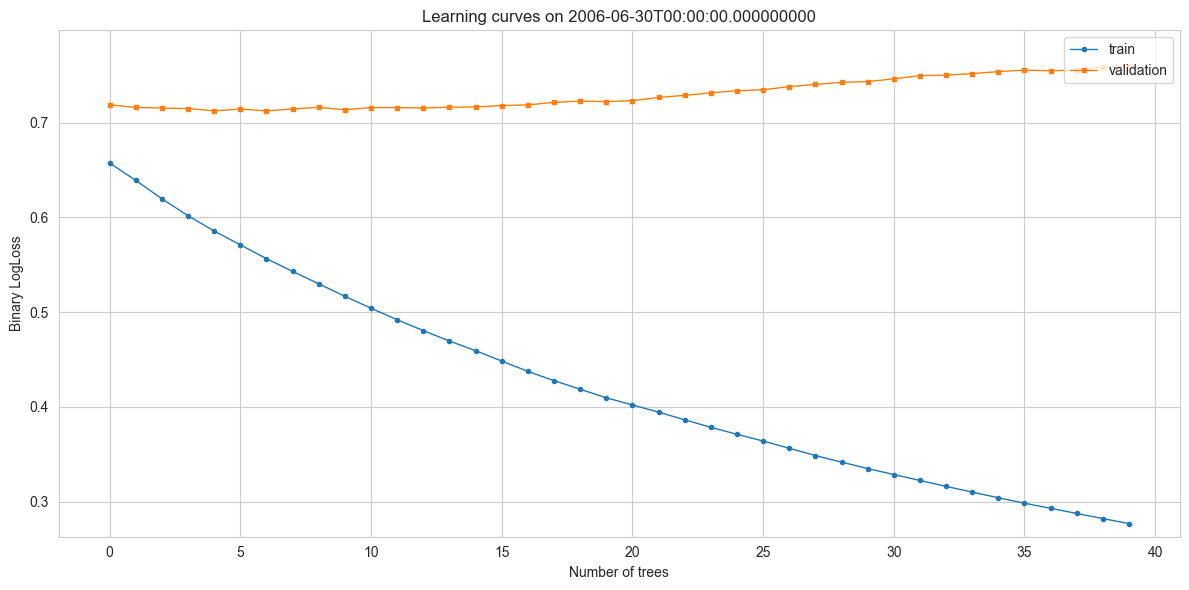

In [48]:
example=execution_dates[4]
plot_learning_curves(example)

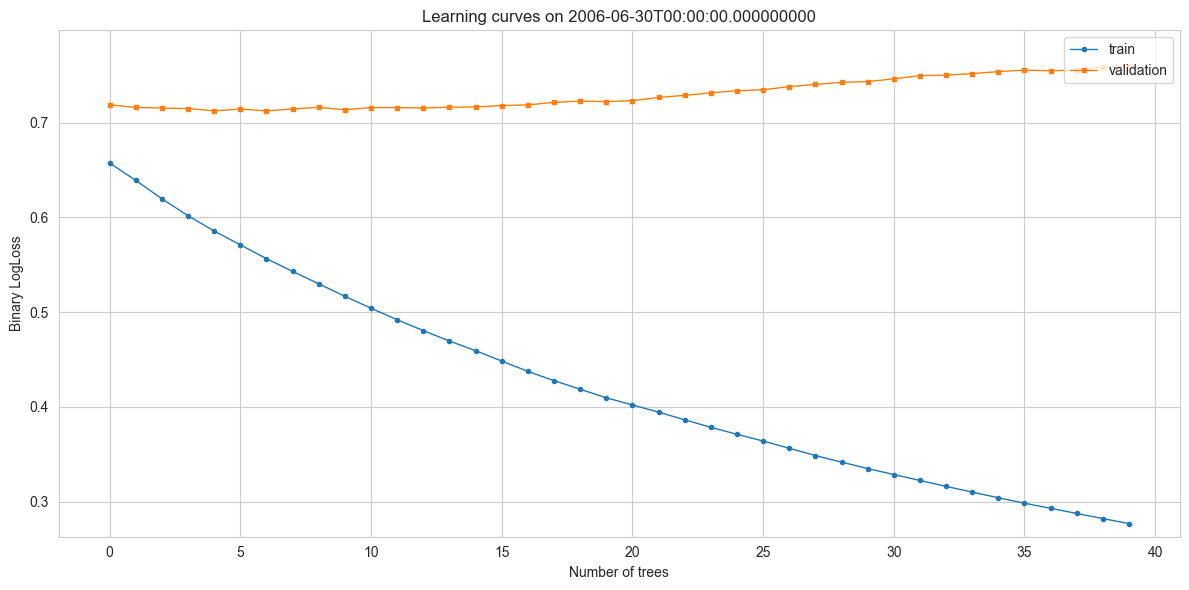

In [49]:
example2=execution_dates[14]
plot_learning_curves(example)

Esta función nos da una idea de lo que esta pasando, el error en train disminuye a medida que aumentan los arboles, comportamiento que no se ve en test. La brecha entre train y test es enorme, indicativo claro de overfitting. Como primer paso esta bien, pero lo suyo seria ver el rendimiento de todos los `execution_date` en una misma visualización, ya que tenemos 1 modelo por cada execution_date. Guille nos propuso en la solución un plot muy interesante

In [50]:
def plot_learning_curves(data, ylim=None):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(12,6))

    box_data = [
        data[data['n_trees_cat'] == tree]['norm_binary_logloss'].values
        for tree in sorted(data['n_trees_cat'].unique())
    ]

    box = ax.boxplot(
        box_data,
        patch_artist=True,
        widths=0.6,
        medianprops={'color':'white'}
    )

    for patch in box['boxes']:
        patch.set_facecolor('#1f77b4')

    ax.set_xticks(range(1, len(box_data) + 1))
    ax.set_xticklabels(sorted(data['n_trees_cat'].unique()))
    ax.set_title("Normalized metric evolution per iteration")
    ax.set_xlabel("Number of trees")
    ax.set_ylabel("norm_binary_logloss")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    if ylim is not None:
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()

In [51]:
def return_learning_curve(set_name):
    lc = pd.concat([
        pd.DataFrame({
            'n_trees':range(len(results[set_name]['binary_logloss'])),
            'binary_logloss': results[set_name]['binary_logloss'],
            'execution_date':date
        }) for date, results in all_results.items() if set_name in results
    ])

    lc['norm_binary_logloss'] = lc.groupby('execution_date')['binary_logloss'].transform(lambda x: (x - x.iloc[0])/x.iloc[0])


    lc['n_trees_cat'] = pd.Categorical(lc['n_trees'], categories=sorted(lc['n_trees'].unique()))

    return lc

    n_trees  binary_logloss execution_date  norm_binary_logloss n_trees_cat
0         0        0.657505     2006-06-30             0.000000           0
1         1        0.639193     2006-06-30            -0.027851           1
2         2        0.619754     2006-06-30            -0.057415           2
3         3        0.601840     2006-06-30            -0.084660           3
4         4        0.585715     2006-06-30            -0.109185           4
..      ...             ...            ...                  ...         ...
35       35        0.621253     2020-03-31            -0.090637          35
36       36        0.620597     2020-03-31            -0.091598          36
37       37        0.619887     2020-03-31            -0.092637          37
38       38        0.619180     2020-03-31            -0.093672          38
39       39        0.618439     2020-03-31            -0.094756          39

[2240 rows x 5 columns]


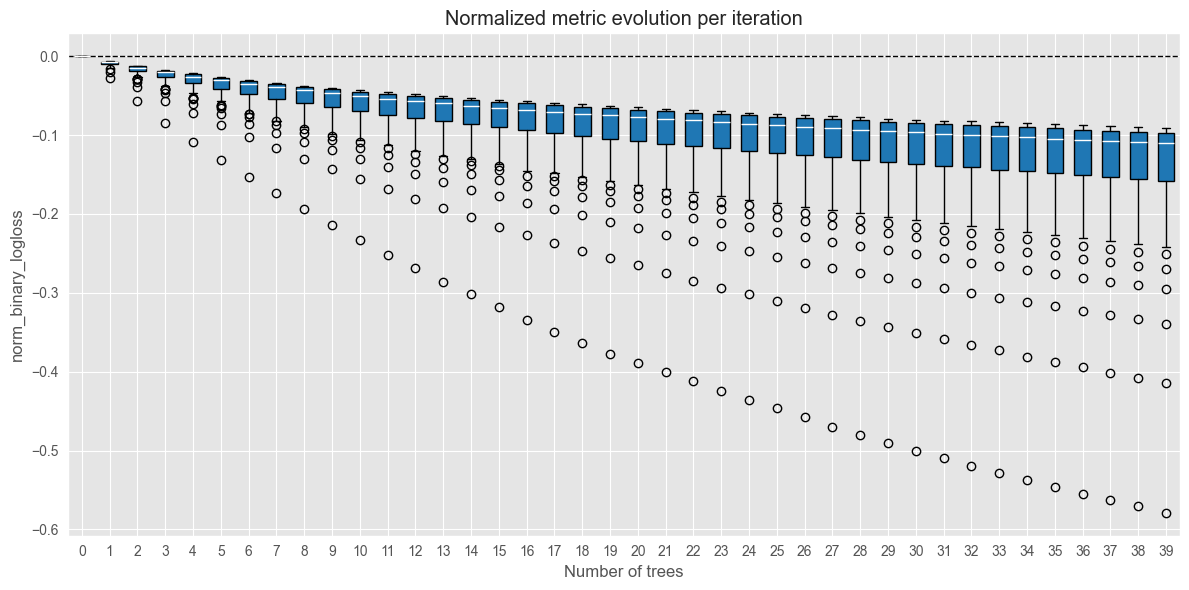

In [52]:
train_lc = return_learning_curve('training')
test_lc = return_learning_curve('valid_0')
print(train_lc)
plot_learning_curves(train_lc)

En train vemos que al aumentar el número de árboles, la función de perdida es baja, la mediana baja moderadamente, pero hay outliers que bajan muchisimo

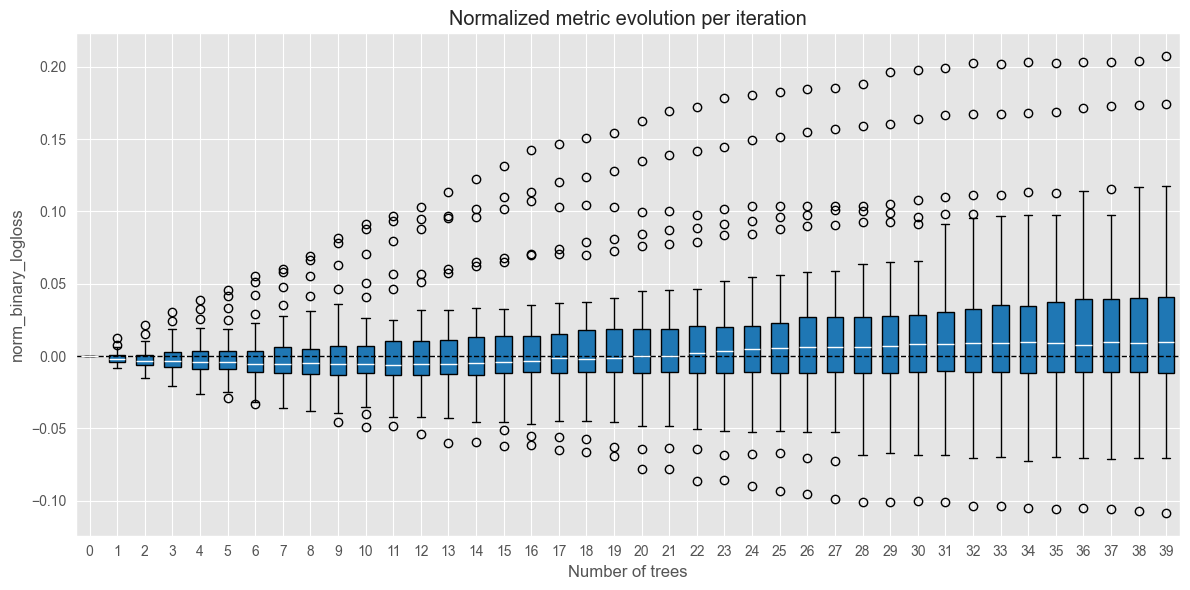

In [53]:
plot_learning_curves(test_lc)

En test, la mediana de la logloss normalizada se mantiene constante, lo cual es malo porque no esta aprendiendo. Además hay outliers que mejoran bastante, pero hay otros outliers que empeoran mucho más, seguramente porque estamos haciendo overfitting. Vamos a hacer zoom en las learning curves de test

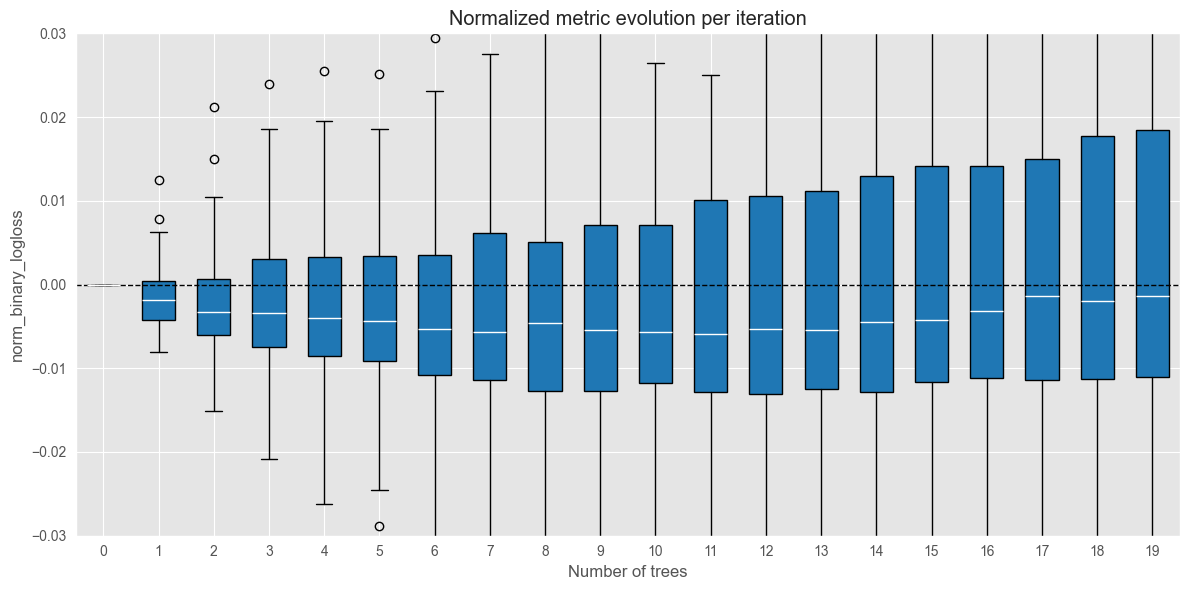

In [54]:
test_lc_filtered = test_lc[test_lc["n_trees"] <= 19]
plot_learning_curves(test_lc_filtered, ylim=(-0.03, 0.03))

Se puede ver que hasta el arbol 10, la mediana baja un poco y despues vuelve a subir

Cuando vemos que un modelo es tan complejo y tiene tanto overfitting, hay que intentar simplificar mucho el modelo y apartir de ahi añadir capas de complejidad.

En particular vamos a probar a modificar estos 4 hiperparametros:

* learning_rate: controla la contribución de un arbol al siguiente

* n_estimators : numero de arboles

* path_smooth: suaviza las predicciones en los nodos terminales para evitar el sobreajuste, especialmente en hojas con pocas muestras.

* num_leaves: cuantas hojas tiene cada arbol

In [55]:
params = {
    "random_state":1,
    "verbosity": -1,
    "n_jobs":10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 10e-3,
    "path_smooth":0.2,
    "n_estimators":20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

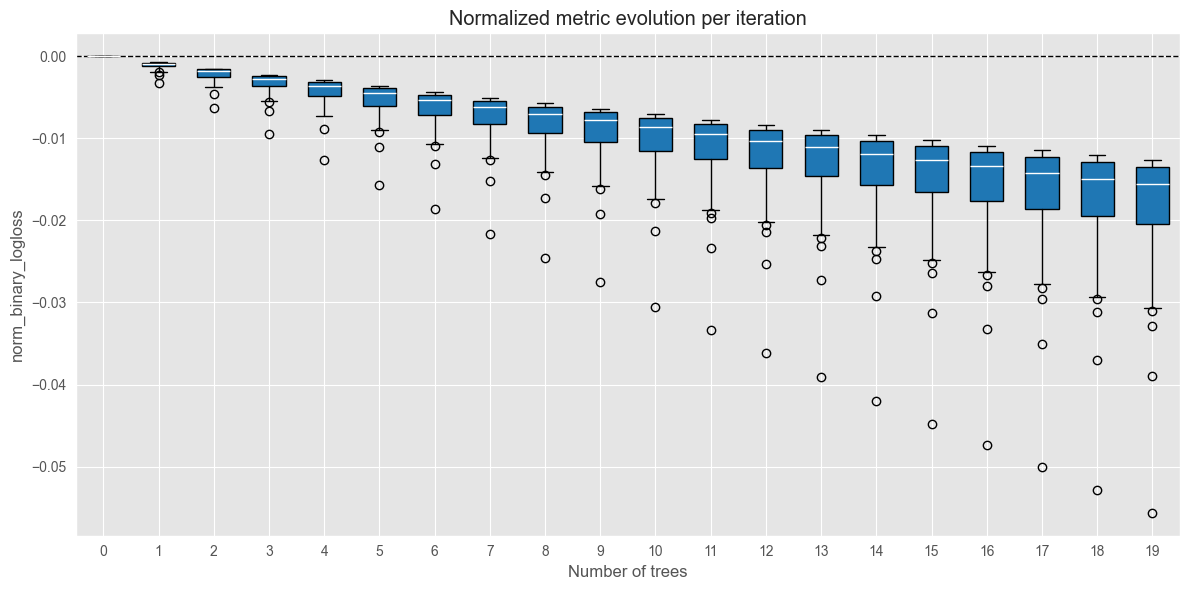

In [56]:
train_lc2 = return_learning_curve('training')
test_lc2 = return_learning_curve('valid_0')
plot_learning_curves(train_lc2)

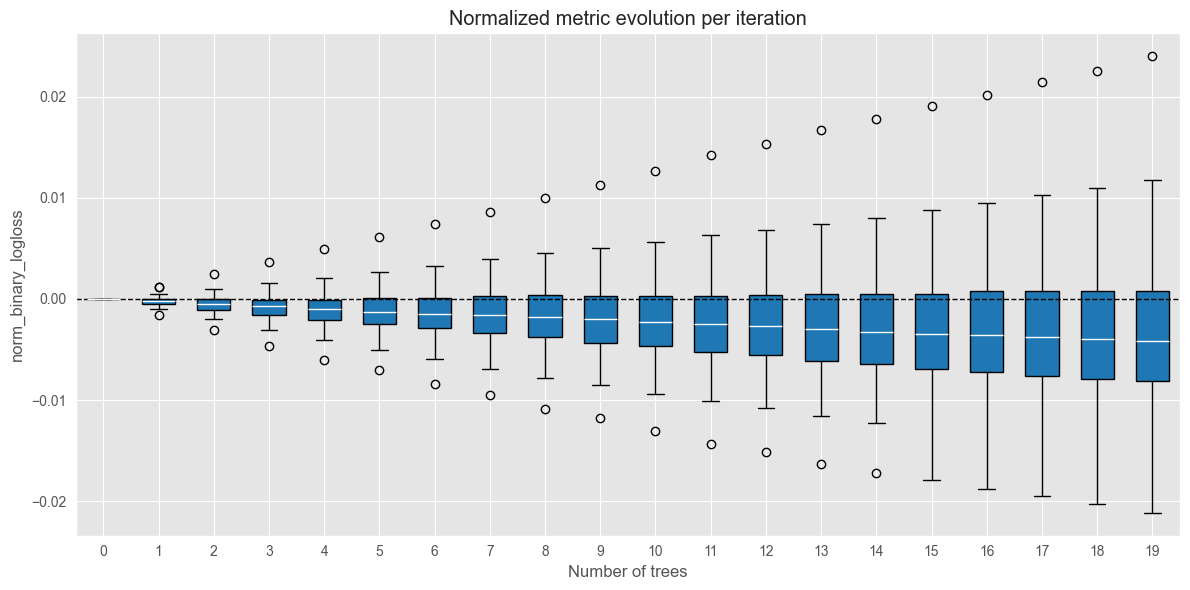

In [57]:
plot_learning_curves(test_lc2)

Pese a seguir haciendo overfitting, en el test set la logloss disminuye a medida que aumenta el numero de arboles, a diferencia del anterior entrenamiento que a partir del 10º arbol volvia a aumentar. Llegados a este punto, aunque el modelo siga haciendo overfitting, vamos a considerar que está más o menos "generalizando" y continuaremos con Feature Importance,uno de los objetivos principales de este modulo

### ***Feature importance***